<a href="https://colab.research.google.com/github/jmsimang/ml-classification/blob/master/Zindi_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ZINDI Fraud Detection

# 1. Libraries & Datasets

## Import Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('white')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score

## Import Data

In [0]:
train_raw = pd.read_csv('./training.csv')
test_raw = pd.read_csv('./test.csv')

In [0]:
train_raw.shape, test_raw.shape

((95662, 16), (45019, 15))

In [0]:
train_raw.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [0]:
test_raw.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


In [0]:
# train_raw['ProductId'].value_counts()

# 2. EDA

## Standardize amount variable

Let's standardize the amount variable to use a smaller scale

In [0]:
train_raw['Amount'] = StandardScaler().fit_transform(train_raw[['Amount']])
train_raw['Value'] = StandardScaler().fit_transform(train_raw[['Value']])
test_raw['Amount'] = StandardScaler().fit_transform(test_raw[['Amount']])
test_raw['Value'] = StandardScaler().fit_transform(test_raw[['Value']])

## Output variable

Let's save the output variable and the length of both datasets

In [0]:
y = train_raw['FraudResult']
# X = train_raw[['ProviderId', 'ChannelId', 'Amount', 'TransactionStartTime', 'PricingStrategy']]
X = train_raw[['AccountId','CustomerId', 'ProductId', 'ProductCategory', 'Value', 'TransactionStartTime', 'PricingStrategy', 'ChannelId']].copy()

test_transaction_id = test_raw['TransactionId']
test = test_raw[['AccountId','CustomerId', 'ProductId', 'ProductCategory', 'Value', 'TransactionStartTime', 'PricingStrategy', 'ChannelId']].copy()


In [0]:
X2 = train_raw.drop('FraudResult', axis=1)
test2 = test_raw.copy()

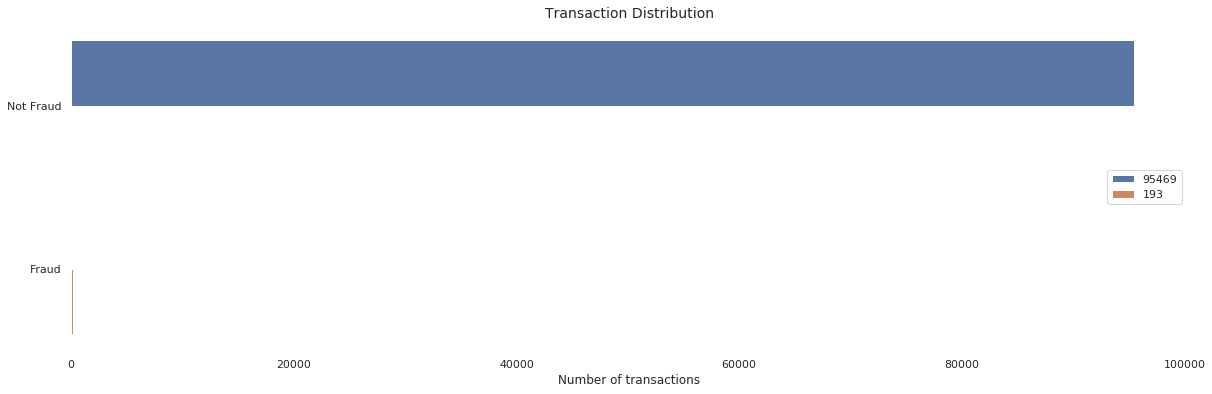

In [0]:
fig, ax = plt.subplots(figsize=(20, 6))
ax = sns.countplot(y='FraudResult', hue='FraudResult', data=train_raw)
ax.set_yticklabels(['Not Fraud', 'Fraud'])
sns.despine(left=True, bottom=True, top=True, right=True)
plt.xlabel('Number of transactions')
plt.ylabel('')
plt.title('Transaction Distribution', fontsize=14)
plt.legend(train_raw.FraudResult.value_counts(), loc='center right')
plt.show()

In [0]:
np.round((len(train_raw.loc[train_raw.FraudResult==1])) / (len(train_raw.loc[train_raw.FraudResult == 0])) * 100, 4)

0.2022

The above graph shows an imbalance in the data where 0.20% of the training dataset belongs to the Fraudulent transactions.

This is a problem because many machine learning models are designed to maximize overall accuracy, which especially with imbalanced classes may not be the best metric to use.

## Split Data

### One-Hot Encoding for non-numeric features (this is needed by the classifier)

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
# Create the encoder.
encoder = OneHotEncoder(handle_unknown='ignore')
encoder2 = OneHotEncoder(handle_unknown='ignore')

In [0]:
encoder.fit(X)
encoder2.fit(X2)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [0]:
X_transformed = encoder.transform(X)
test_transformed = encoder.transform(test)

In [0]:
X_transformed2 = encoder2.transform(X2)
test_transformed2 = encoder2.transform(test2)

In [0]:
# Transforming the Features
X_transformed, test_transformed

(<95662x103488 sparse matrix of type '<class 'numpy.float64'>'
 	with 765296 stored elements in Compressed Sparse Row format>,
 <45019x103488 sparse matrix of type '<class 'numpy.float64'>'
 	with 246278 stored elements in Compressed Sparse Row format>)

In [0]:
X_transformed2, test_transformed2

(<95662x299270 sparse matrix of type '<class 'numpy.float64'>'
 	with 1434930 stored elements in Compressed Sparse Row format>,
 <45019x299270 sparse matrix of type '<class 'numpy.float64'>'
 	with 416403 stored elements in Compressed Sparse Row format>)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_transformed2, y, test_size=0.25, random_state=42)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((71746, 103488), (23916, 103488), (71746,), (23916,))

In [0]:
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((71746, 299270), (23916, 299270), (71746,), (23916,))

We can then proceed to create our classification model.

## Machine Learning Classifier

In [0]:
log_reg = LogisticRegression(C=90, solver='liblinear', class_weight='balanced')
log_reg2 = LogisticRegression(C=90, solver='liblinear', class_weight='balanced', n_jobs=12)

In [0]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=90, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
log_reg2.fit(X_train2, y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=90, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=12, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_log_reg = log_reg.predict(X_test)
y_pred_log_reg2 = log_reg2.predict(X_test2)

In [0]:
f1_score(y_test, y_pred_log_reg), f1_score(y_test2, y_pred_log_reg2)

(0.8541666666666667, 0.8817204301075269)

In [0]:
print(classification_report(y_test, y_pred_log_reg, target_names=['Not fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not fraud       1.00      1.00      1.00     23869
       Fraud       0.84      0.87      0.85        47

    accuracy                           1.00     23916
   macro avg       0.92      0.94      0.93     23916
weighted avg       1.00      1.00      1.00     23916



In [0]:
print(classification_report(y_test2, y_pred_log_reg2, target_names=['Not fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not fraud       1.00      1.00      1.00     23869
       Fraud       0.89      0.87      0.88        47

    accuracy                           1.00     23916
   macro avg       0.95      0.94      0.94     23916
weighted avg       1.00      1.00      1.00     23916



### Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rfc = RandomForestClassifier(n_estimators=150, class_weight='balanced')
rfc2 = RandomForestClassifier(n_estimators=150, class_weight='balanced')

In [0]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [0]:
rfc2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred_rfc = rfc.predict(X_test)
y_pred_rfc2 = rfc2.predict(X_test2)

In [0]:
print(classification_report(y_test, y_pred_rfc, target_names=['Not fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not fraud       1.00      1.00      1.00     23869
       Fraud       0.96      0.55      0.70        47

    accuracy                           1.00     23916
   macro avg       0.98      0.78      0.85     23916
weighted avg       1.00      1.00      1.00     23916



In [0]:
print(classification_report(y_test2, y_pred_rfc2, target_names=['Not fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not fraud       1.00      1.00      1.00     23869
       Fraud       0.94      0.32      0.48        47

    accuracy                           1.00     23916
   macro avg       0.97      0.66      0.74     23916
weighted avg       1.00      1.00      1.00     23916



In [0]:
f1_score(y_test, y_pred_rfc), f1_score(y_test2, y_pred_rfc2)

(0.7027027027027027, 0.4761904761904763)

## Submission

Random Forest Classifier

In [0]:
# y_rfc_submission = rfc.predict(test_transformed)

In [0]:
# submission_rfc = pd.DataFrame()
# submission_rfc['TransactionId'] = test_transaction_id
# submission_rfc['FraudResult'] = y_rfc_submission

In [0]:
# submission_rfc.to_csv('./RFC_Detection_Final.csv', index=False)

Lowest score from Logistic Regression classifier.

In [0]:
y_log_reg_submission = log_reg2.predict(test_transformed2)

In [0]:
submission_log = pd.DataFrame()
submission_log['TransactionId'] = test_transaction_id
submission_log['FraudResult'] = y_log_reg_submission

In [0]:
submission_log.to_csv('./LogR_Detection_Final.csv', index=False)